# network generation and analysis

In [1]:
import networkx as nx
import pandas as pd
import itertools as it
from scipy.stats import spearmanr, pearsonr
import matplotlib.pyplot as plt
import matplotlib as mpl
import csv
from thefuzz import fuzz
from statsmodels.stats.multitest import fdrcorrection
mpl.rcParams['pdf.fonttype'] = 42

def get_unambiguous_column_names(column_names):
    series = pd.Series(column_names)
    series[series.duplicated(keep = 'first')] = series[series.duplicated(keep = 'first')].apply(
        lambda x: x + '.1'
    )
    return series.to_list()

def parse_metabolomics_results(filename, delimiter = ',', quotechar = '"'):
    with open(filename) as csvfile:
        data = []
        entryid = None
        csvreader = csv.reader(
            csvfile,
            delimiter = delimiter,
            quotechar = quotechar
        )
        
        # get column names and make them unambiguous
        names = []
        for i in range(2):
            names = csvreader.__next__()
        
        names = get_unambiguous_column_names(names)
        
        add_names = [
                'Name2', 
                'Molecular Weight', 
                'RT [min]2', 
                'DeltaMass [ppm]', 
                'DBID', 
                'Reference List Name', 
                'mzLogic Score', 
                'ChemSpider ID', 
                'KEGG', 'HMDB', 
                'Mass List Search Results ID'
        ]
        add_names_set = set([k if not k in {'Name2', 'RT [min]2'} else k[:-1] for k in add_names]) # faster check
        series = None
        tmp_names = []
        add_rows = []
        
        def insert_addrow_into_series(series, names, values, add_names_set):
            series = series.copy()
            for k, v in zip(names, values):
                if k in add_names_set:
                    k = k + '2' if k in {'Name', 'RT [min]'} else k
                    series[k] = v if v else None

                elif k == 'KEGG ID':
                    series['KEGG'] = v if v else None
            
            return series
            
        for line in csvreader:
            if line[0]:
                if add_rows:
                    exact_match = False
                    partial_match = False
                    for row in add_rows:
                        if row[0] == series.Name:
                            data.append(
                                insert_addrow_into_series(
                                    series,
                                    tmp_names,
                                    row,
                                    add_names_set
                                )
                            )
                            exact_match = True
                            break
                    
                    if not exact_match:
                        for row in add_rows:
                            if fuzz.partial_ratio(row[0].lower(), series.Name.lower()) > 95:
                                data.append(
                                    insert_addrow_into_series(
                                        series,
                                        tmp_names,
                                        row,
                                        add_names_set
                                    )
                                )
                                partial_match = True
                                break
                    
                    if not partial_match:
                        data.append(series.copy())
                
                elif isinstance(series, pd.Series):
                    data.append(series.copy())
                    
                entryid = line[0]
                add_rows = []
                series = pd.Series(
                    {k: v for k, v in zip(names, line)}
                )
                
            elif line[1] == 'Name':
                tmp_names = [name for name in line if name]
            
            else:
                add_rows.append(line[1: 1 + len(tmp_names)])
    
    return pd.DataFrame(data, columns = names + add_names)

def clean_dataframe(df):
    no_kegg_rows = df.KEGG.isna()
    no_kegg = df.loc[no_kegg_rows, :].copy()
    kegg = df.loc[~no_kegg_rows, :].copy()
    for df in [kegg, no_kegg]:
        df.drop_duplicates(
            subset = ['ID', 'KEGG'],
            inplace = True
        )
    
    no_kegg = no_kegg.loc[~no_kegg.ID.isin(kegg.ID), :]
    return kegg, no_kegg

from scipy import integrate
def disparity_filter(G, alpha, weight = 'weight'):
    '''
    Implementation of disparity filter accroding to https://doi.org/10.1515%2Fjib-2021-0030
    basically a port of https://github.com/alessandrobessi/disparityfilter
    '''
    
    G_f = nx.Graph()
    attrs = {}
    for u, attr_dict in G.nodes(data = True):
        attrs[u] = attr_dict
        k = len(G[u])
        sum_w = sum(e[weight] for e in G[u].values())
        for v, d in G[u].items():
            # log prevents overflow warning in case of high exponents
            alpha_ij = np.log((1 - d[weight]/sum_w)) * (k - 1)
            if alpha_ij < np.log(alpha):
                G_f.add_edge(*sorted([u, v]), alpha = alpha_ij, **d)
                
    nx.set_node_attributes(
        G_f,
        attrs
    )
    
    return G_f

def disparity_filter_salvo(G, alpha, weight = 'weight'):
    '''
    Implementation of disparity filter as originally described in https://doi.org/10.1073/pnas.0808904106
    Code generously provided by Salvo D. Lombardo
    '''
    
    B = nx.Graph()
    for u in G:
        k = len(G[u])
        if k > 1:
            sum_w = sum(np.absolute(G[u][v][weight]) for v in G[u])
            for v in G[u]:
                w = G[u][v][weight]
                p_ij = float(np.absolute(w))/sum_w
                alpha_ij = 1 - (k-1) * integrate.quad(lambda x: (1-x)**(k-2), 0, p_ij)[0]
                if alpha_ij < alpha:
                    B.add_edge(u, v, weight = w, alpha=float('%.4f' % alpha_ij))
                    
    return B

def filter_by_pvalue(edges, pvals, alpha, fdr_correction = True):
    if not isinstance(pvals, np.ndarray):
        pvals = np.array(pvals)
    
    if not isinstance(edges, np.ndarray):
        edges = np.array(edges)
        
    if fdr_correction:
        reject, padj = fdrcorrection(
            pvals,
            alpha = alpha,
            method = 'indep'
        )
    
    else:
        reject = pvals <= alpha
        padj = pvals
    
    return edges[reject]
    
def make_correlation_network(
    data1, 
    regex1, 
    data2 = None, 
    regex2 = None, 
    apply_threshold_to = None, 
    threshold = None,
    corr_method = 'spearman',
    fdr_correction = True
):
    corr_methods = {
        'spearman': spearmanr,
        'pearson': pearsonr
    }
    G = nx.Graph()
    G.add_nodes_from(
        [make_node(row) for i, row in data.iterrows()]
    )
    gtdata1 = data1.loc[
        :, 
        data1.columns[
            data1.columns.str.match(regex1)
        ]
    ].astype(float)
    
    if not isinstance(data2, pd.DataFrame):
        gtdata2 = gtdata1
        pair_generator = it.combinations(
            enumerate(gtdata1.index), 2
        )
        
    else:
        gtdata2 = data2.loc[
            :, 
            data2.columns[
                data2.columns.str.match(regex2)
            ]
        ].astype(float)
        
        pair_generator = it.product(
            enumerate(gtdata1.index), 
            enumerate(gtdata2.index)
        )
    

    edges, pvalues = [], []
    for (i, m1), (j, m2) in pair_generator:
        r, p = corr_methods[corr_method](
            gtdata1.loc[m1, :], gtdata2.loc[m2, :]
        )
        
        edges.append(
            (m1, m2, {'weight': r, 'absweight': abs(r), 'pval': p})
        )
        pvalues.append(p)
    
    if apply_threshold_to == 'pval':
        filtered_edges = filter_by_pvalue(
            edges,
            pvalues,
            alpha = threshold,
            fdr_correction = fdr_correction
        )
    
    elif apply_threshold_to == 'corr':
        filtered_edges = [e for e in edges if e[2]['absweight'] >= threshold]
    
    else:
        filtered_edges = edges
        
    G.add_edges_from(
        filtered_edges
    )
    return G, (gtdata1, gtdata2)

def get_node_attr_dict(df, attr_name, attr_column):
    attrs = {}
    for node, row in df.iterrows():
        attrs[node] = {attr_name: row[attr_column]}
    
    return attrs

In [2]:
hilic = parse_metabolomics_results('../raw/Results_Untargeted_Metabolomics_E14-P40_LK_Nova_results_HILIC.csv')
hilic, no_kegg_hilic = clean_dataframe(hilic)
rp = parse_metabolomics_results('../raw/Results_Untargeted_Metabolomics_E14-P40_LK_Nova_results_RP.csv')
rp, no_kegg_rp = clean_dataframe(rp)

In [3]:
# combine hilic and rp in two different ways
def get_clean_coarse_group(x):
    x = x.split('/')[0].strip().lower()
    if x.startswith('bio'):
        x = 'bioenergetic process'
        
    elif x.startswith('nucleoside'):
        x = 'nucleoside metabolism'
    
    elif x.startswith('glycolysis'):
        x = 'glycolysis'
    
    elif x.startswith('lipid'):
        x = 'lipid metablism'
    
    elif x.startswith('purine'):
        x = 'nucleoside metabolism'
        
    elif x.startswith('aa'):
        x = 'aa metabolism'
        
    else:
        x = 'other'
        
    return x

basedata = {}
for key in ['RP', 'HILIC']:
    base = pd.read_csv(
        f'../raw/untargeted_Metabo_Results_LKnaus_annotated_DM_clean_annot_{key}.csv',
        header = 1
    ).loc[:, ['ID', 'Name Metabolite ', 'Group ']]
    base.columns = ['ID', 'metabolitename', 'metabolitegroupfine']
    base['metabolitegroupcoarse'] = base.metabolitegroupfine.apply(
        get_clean_coarse_group
    )

    frames = []
    for df in [hilic, no_kegg_hilic, rp, no_kegg_rp]:
        frames.append(
            base.merge(
                df,
                on = 'ID',
                how = 'inner'
            )
        )
    
    df = pd.concat(frames).reset_index(drop = True)
    df.index = df.ID.to_list()
    basedata[key] = df

In [90]:
data = basedata['HILIC']
data_cols = data.columns[data.columns.str.match('S[0-9]{2}_[EP][0-9][_0-9]+WT[0-9]')].to_list()
data_col_grouping = [c[4:-4] for c in data_cols] 
gm_data = data.loc[:, data_cols].astype(float)
gm_data = gm_data.T
gm_data = gm_data.groupby(data_col_grouping).mean().T
add_value = 100000000
gm_data = gm_data.apply(
    lambda x: (x - x.min() + add_value) / (x.max() - x.min() + add_value),
    axis = 1
)
gm_data

,E14_5,P2,P40
A002_HILIC,1.000000,0.102560,0.431495
A054_HILIC,0.183784,0.086660,1.000000
A062_HILIC,1.000000,0.931463,0.374522
B122_HILIC,1.000000,0.005200,0.977501
A012_HILIC,0.894028,0.191887,1.000000
...,...,...,...
C166_RP,0.588118,0.594574,1.000000
C164_RP,0.881575,0.671852,1.000000
C161_RP,0.707071,1.000000,0.646784
C116_RP,0.897467,1.000000,0.246881


In [93]:
import numpy as np
def make_node(row):
    node = (
        row['ID'],
        {
            'name': row['metabolitename'],
            'group': row['metabolitegroupcoarse']
        }
    )
    return node
    
data = basedata['HILIC']
networks, gtdatas = {}, {}
genotype = 'WT'
for timepoint in ['E14_5', 'P2', 'P40']:
    G, (gtdata, _) = make_correlation_network(
        data,
        'S[0-9]{2}_' + timepoint + '_' + genotype + '[0-9]',
        corr_method = 'spearman',
        # threshold = 0.5,
        # apply_threshold_to = 'corr',
        # fdr_correction = True
    )
    
    nx.set_node_attributes(
        G,
        get_node_attr_dict(gm_data, 'weight', timepoint)
    )
    gtdatas[timepoint] = gtdata
    networks[timepoint] = G

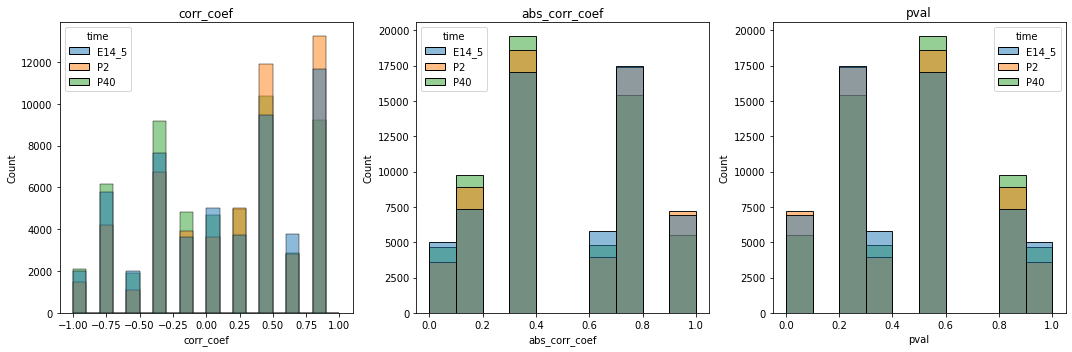

In [15]:
import seaborn as sns
data = []
for k, G in networks.items():
    for node1, node2, edata in G.edges(data = True):
        data.append(
            [k, edata['weight'], edata['absweight'], edata['pval']]
        )

data = pd.DataFrame(
    data,
    columns = ['time', 'corr_coef', 'abs_corr_coef', 'pval']
)
fig, axs = plt.subplots(1, 3)
for x, binrange, ax in zip(
    ['corr_coef', 'abs_corr_coef', 'pval'], 
    [(-1, 1), (0, 1), (0, 1)],
    axs
):
    sns.histplot(
        x = x,
        data = data,
        hue = 'time',
        binwidth = 0.1,
        binrange = binrange,
        ax = ax
    )
    ax.set_title(x)

fig.set_figwidth(15)
fig.set_figheight(5)
fig.tight_layout()

lccs =  {}  with alpha =  0.05
lccs =  {'E14_5': 21, 'P2': 13, 'P40': 18}  with alpha =  0.1
lccs =  {'E14_5': 160, 'P2': 54, 'P40': 42}  with alpha =  0.15000000000000002
lccs =  {'E14_5': 267, 'P2': 265, 'P40': 293}  with alpha =  0.2
lccs =  {'E14_5': 346, 'P2': 346, 'P40': 346}  with alpha =  0.25
lccs =  {'E14_5': 346, 'P2': 346, 'P40': 346}  with alpha =  0.3
lccs =  {'E14_5': 346, 'P2': 346, 'P40': 346}  with alpha =  0.35000000000000003
lccs =  {'E14_5': 346, 'P2': 346, 'P40': 346}  with alpha =  0.4
lccs =  {'E14_5': 346, 'P2': 346, 'P40': 346}  with alpha =  0.45
lccs =  {'E14_5': 346, 'P2': 346, 'P40': 346}  with alpha =  0.5


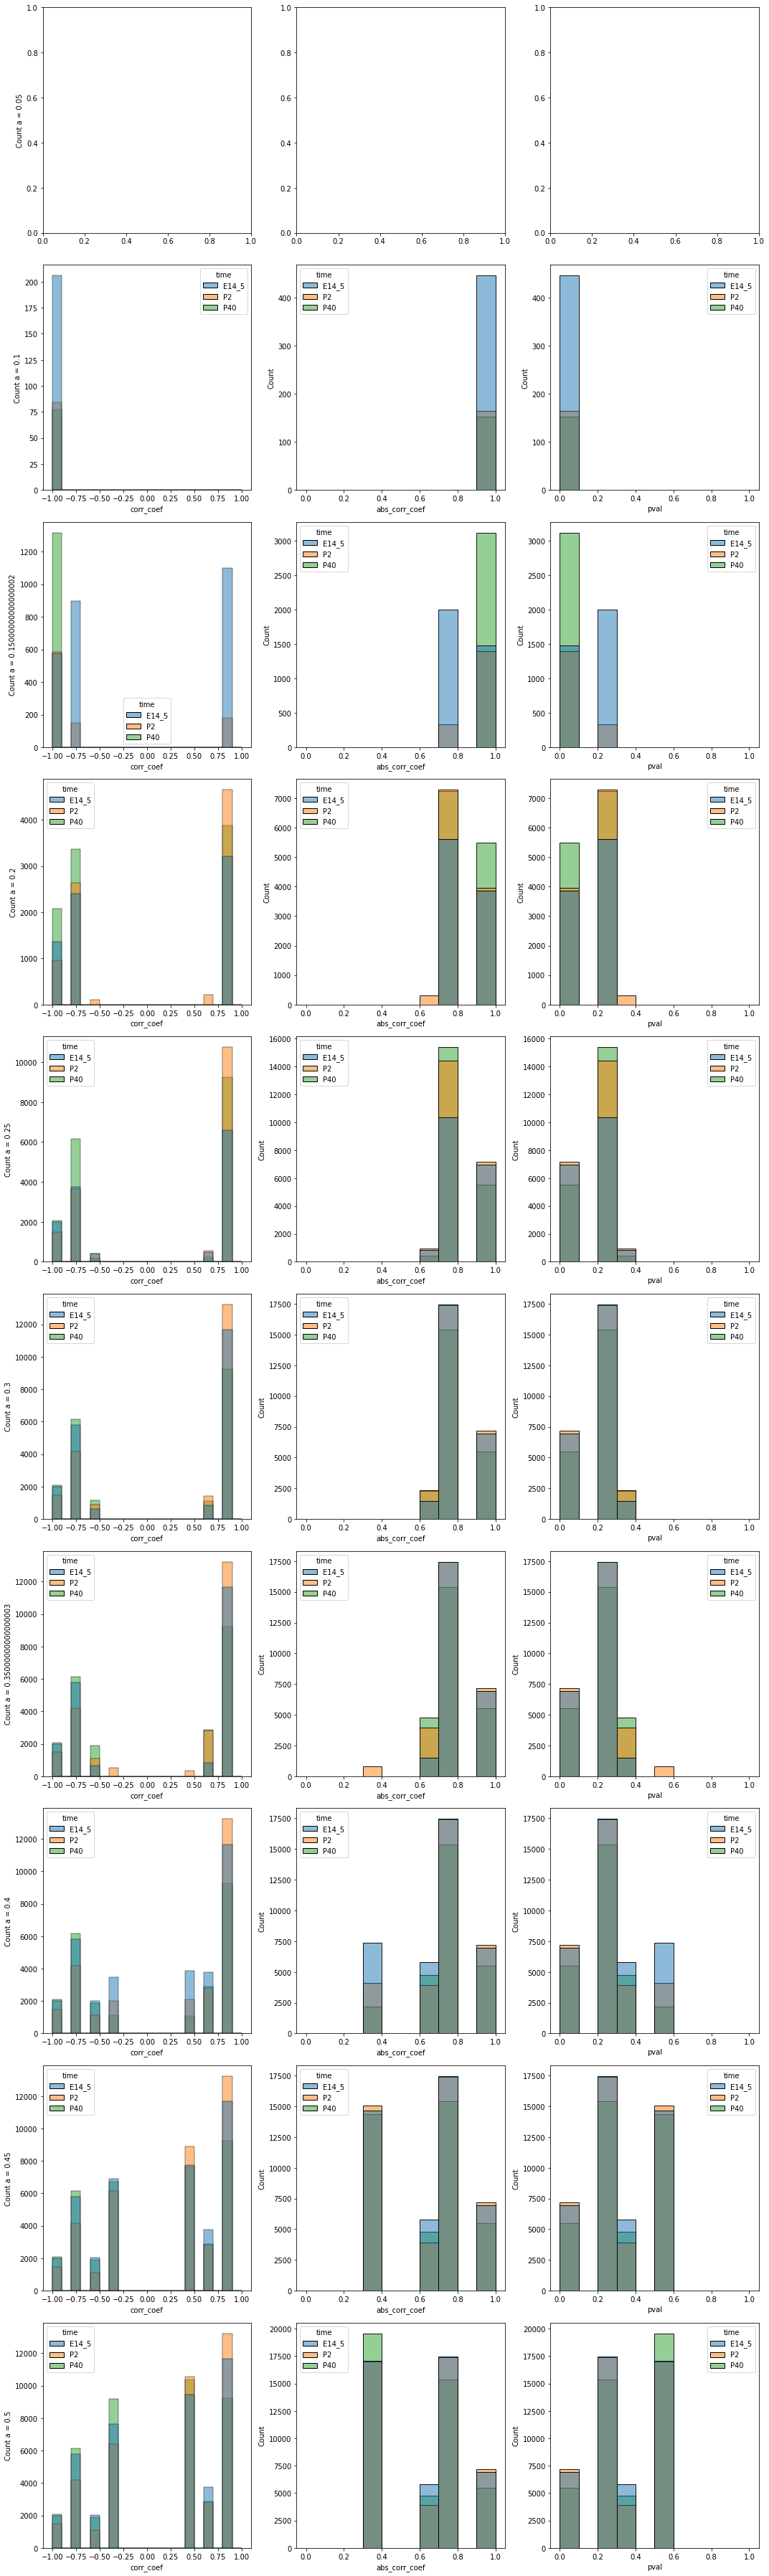

In [8]:
fig, axs = plt.subplots(10, 3)
for i, alpha in enumerate(np.arange(0.05, 0.55, 0.05)):
    data = []
    lccs = {}
    for k, G in networks.items():
        G_filter = disparity_filter(
            G,
            alpha,
            'absweight'
        )
        if G_filter.number_of_edges():
            lccs[k] = max([len(lcc) for lcc in nx.connected_components(G_filter)])
        
        for node1, node2, edata in G_filter.edges(data = True):
            data.append(
                [k, edata['weight'], edata['absweight'], edata['pval']]
            )
    
    print('lccs = ', lccs, ' with alpha = ', alpha)
    data = pd.DataFrame(
        data,
        columns = ['time', 'corr_coef', 'abs_corr_coef', 'pval']
    )
    
    for x, binrange, ax in zip(
        ['corr_coef', 'abs_corr_coef', 'pval'], 
        [(-1, 1), (0, 1), (0, 1)],
        axs[i, :]
    ):
        sns.histplot(
            x = x,
            data = data,
            hue = 'time',
            binwidth = 0.1,
            binrange = binrange,
            ax = ax
        )
        
    axs[i, 0].set_ylabel(f'Count a = {alpha}')

fig.set_figwidth(15)
fig.set_figheight(50)
fig.tight_layout()

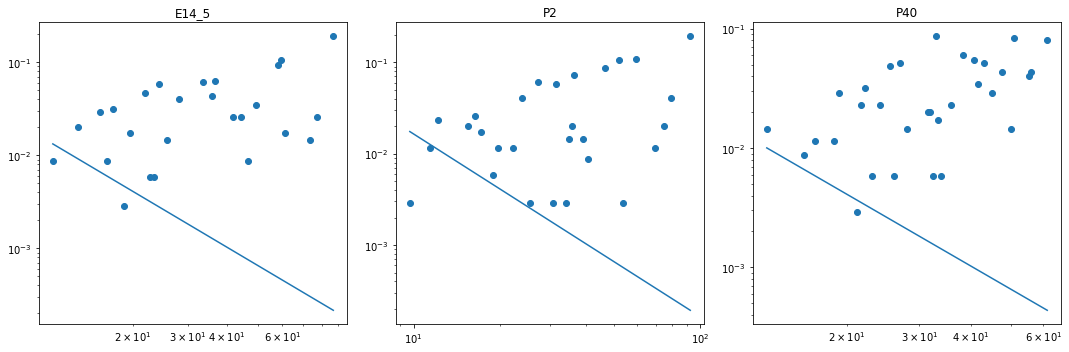

In [53]:
from collections import defaultdict
from scipy.special import zeta
def degree_sequence(G, weight = 'weight', exponent = 1):
    degrees = defaultdict(float)
    for node1, node2, edata in G.edges(data = True):
        for node in [node1, node2]:
            degrees[node] += edata[weight] ** exponent
    
    return np.array([v for v in degrees.values()])

def degree_distribution(G, weight = 'weight', bins = None, exponent = 1):
    dist = defaultdict(int)
    dseq = degree_sequence(G, weight, exponent = exponent)
    if not bins:
        for degree in dseq:
            dist[degree] += 1
        
        dist = np.array(
            [[d, n/len(dseq)] for d, n in dist.items()]
        )
    
    else:
        hist, binedges = np.histogram(
            dseq,
            bins = bins
        )
        
        dist = np.array(
            [[d, n/len(dseq)] for d, n in zip(binedges[:-1], hist)]
        )
        
    return dist[:, 0], dist[:, 1]

fig, axs = plt.subplots(1, 3)
for (k, G), ax in zip(networks.items(), axs):
    degrees, probs = degree_distribution(G, 'absweight', 100, exponent = 10)
    ax.scatter(
        degrees,
        probs
    )
    ax.plot(
        degrees,
        (degrees ** -2) * zeta(2)
    )
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(k)
    

fig.set_figwidth(15)
fig.set_figheight(5)
fig.tight_layout()   

# bootstrap clustering

In [6]:
from infomap import Infomap
def get_initial_partition_dict(df, column):
    partition = {}
    for i, (_, group) in enumerate(df.groupby(column)):
        for node, row in group.iterrows():
            partition[node] = i + 1
        
    return partition

def get_weights(G, weight = 'weight'):
    return np.array([w for _, _, w in G.edges(data = weight)])

def make_infomap(G, weight = 'weight', node_weight = None, bootstrap = False, **kwargs):
    im = Infomap(**kwargs)
    node_to_id = {}
    for i, (node, ndata) in enumerate(G.nodes(data = True)):
        im.add_node(
            i + 1, 
            name = node, 
            teleportation_weight = ndata[node_weight] if node_weight else None
        )
        node_to_id[node] = i + 1
        
    if bootstrap:
        weights = get_weights(G, weight)
        
    for node1, node2, weight in G.edges(data = weight):
        im.add_link(
            node_to_id[node1],
            node_to_id[node2],
            weight = weight if not bootstrap else np.random.choice(weights)
        )
    
    return im, node_to_id

def get_module_assignments(im, id_to_node):
    assignment = []
    for node_id, module in im.get_modules(depth_level = 1).items():
        assignment.append(
            [id_to_node[node_id], module]
        )
        
    df = pd.DataFrame(
        assignment,
        columns = ['name', 'module']
    )
    return df

def infomap(G, weight = 'weight', node_weight = None, initial_partition = None, bootstrap = False, verbose = True, **kwargs):
    infomap_params = dict(
        flow_model = 'undirected',
        markov_time = 1,
        num_trials = 10,
        silent = True
    )
    infomap_params.update(kwargs)
    
    im, n2i_map = make_infomap(
        G,
        weight,
        node_weight = node_weight,
        bootstrap = bootstrap,
        **infomap_params
    )
    
    if initial_partition:
        initial_partition = {
            n2i_map[k]: v for k, v in initial_partition.items()
        }
        
    im.run(initial_partition = initial_partition)
    
    if verbose:
        print(f'Found {im.num_top_modules} modules using infomap')
        
    module_assignment = get_module_assignments(
        im,
        {v: k for k, v in n2i_map.items()}
    )
    
    return module_assignment

def make_bootstrap_graph(G, weight = 'weight'):
    weights = get_weights(G, weight)
    G = G.copy()
    update_dict = {}
    for n1, n2, edata in G.edges(data = weight):
        update_dict[(n1, n2)] = {weight: np.random.choice(weights)}
    
    nx.set_edge_attributes(G, update_dict)
    return G
    
    
def louvain(G, weight = 'weight', resolution = 1, bootstrap = False, verbose = True, **kwargs):
    if bootstrap:
        G = make_bootstrap_graph(G, weight)
        
    communities = nx.algorithms.community.louvain_communities(
        G, 
        weight, 
        resolution
    )
    if verbose:
        print(f'Found {len(communities)} modules using lovain')
        
    module_assignment = []
    for i, module in enumerate(communities):
        for node in module:
            module_assignment.append(
                [node, i + 1]
            )
    
    return pd.DataFrame(module_assignment, columns = ['name', 'module'])
    
def bootstrap_clustering(G, clusterfunc, weight = 'weight', n = 1000, verbose = True, **kwargs):
    bootstrap_assignments = clusterfunc(
        G,
        weight,
        verbose = verbose,
        **kwargs
    )
    bootstrap_assignments.rename(
        columns = {'module': 'assignments_0'},
        inplace = True
    )
    
    # bootstrap
    for i in range(n):
        tmp_assignments = clusterfunc(
            G,
            weight,
            bootstrap = True,
            verbose = verbose,
            **kwargs
        )
            
        bootstrap_assignments = bootstrap_assignments.merge(
            tmp_assignments.rename(columns = {'module': f'assignments_{i + 1}'}),
            on = 'name',
            how = 'left'
        )
    
    return bootstrap_assignments

In [7]:
# code to test functions from above
# data = basedata['HILIC']
# df = bootstrap_clustering(
#     disparity_filter(G, 0.2, 'absweight'), 
#     infomap,
#     'absweight',
#     n = 3,
#     node_weight = 'weight',
#     markov_time = 1, 
#     # initial_partition = get_initial_partition_dict(data, 'metabolitegroupcoarse'),
#     # use_node_weights_as_flow = True,
#     # silent = False
# )

df = bootstrap_clustering(
    disparity_filter(G, 0.25, 'absweight'), 
    louvain,
    'absweight',
    resolution = 1.5,
    n = 10
)

Found 4 modules using lovain
Found 5 modules using lovain
Found 4 modules using lovain
Found 4 modules using lovain
Found 5 modules using lovain
Found 5 modules using lovain
Found 5 modules using lovain
Found 5 modules using lovain
Found 4 modules using lovain
Found 5 modules using lovain
Found 4 modules using lovain


In [8]:
data = basedata['HILIC']
bootstraps = {
    'infomap': {},
    'louvain': {}
}
for k, func in zip(['infomap', 'louvain'], [infomap, louvain]):
    for t, G in networks.items():
        params = {'markov_time': 1} if k == 'infomap' else {'resolution': 1.5}
        bootstrap = bootstrap_clustering(
            disparity_filter(G, 0.25, 'absweight'),
            func,
            'absweight',
            verbose = False,
            **params
        )
        
        bootstrap.to_csv(
            f'../data/sigclust_bootstrap_{t}_{k}.tsv',
            sep = '\t',
            index = False
        )
        bootstraps[k][t] = bootstrap

In [9]:
%%script bash
for file in `ls ../data/sigclust_*.tsv`;
do
    tail -n +2 $file | cut -f 1 --complement > ${file%.*}_nhfc.tsv
    /users/daniel.malzl/significance-clustering/sigclu \
        -s 3746 \
        -c 0.95 \
        ${file%.*}_nhfc.tsv \
        ${file%.*}_sigclust.tsv \
        ${file%.*}_sigmod.tsv
done

Setup:
-->Using seed: 3746
-->Confidence level: 0.95
-->Reading from partitions file: ../data/sigclust_bootstrap_E14_5_infomap_nhfc.tsv
-->No weights file provided. Using uniform weights of nodes in signifificance clustering.
-->Writing results to files: ../data/sigclust_bootstrap_E14_5_infomap_sigclust.tsv and ../data/sigclust_bootstrap_E14_5_infomap_sigmod.tsv
Reading partitions file with 1 + 1000 partitions of 346 nodes...done!

MCMC to maximize significant core of modules, enumerated by sizes with module id in parenthesis:
module 1 (1): 106/150 confident nodes and 0.306358/0.433526 (70.6667 percent) of the flow.
module 2 (2): 98/98 confident nodes and 0.283237/0.283237 (100 percent) of the flow.
module 3 (3): 98/98 confident nodes and 0.283237/0.283237 (100 percent) of the flow.

Now calculate number of times two modules are clustered together, enumerated by size with module id in parenthesis:
Module 1 (1) is standalone 1000/1000 times.
Module 2 (2) is standalone 487/1000 times and

In [75]:
import pandas as pd
from collections import defaultdict

def dfs(graph, node, path):
    path.add(node)
    
    for neighbor in graph[node]:
        if neighbor not in path:
            path = dfs(graph, neighbor, path)
    
    return path

def get_not_standalone_groups(sigmodfiles):
    not_standalone = {}
    for k, sigmodfile in sigmodfiles.items():
        not_standalone_graph = defaultdict(set)
        with open(sigmodfile, 'r') as f:
            for line in f:
                if line.startswith('#') or line.startswith('module'):
                    continue
            
                else:
                    edge = line.rstrip().split()
                    for i, j in [[0, 1], [1, 0]]:
                        not_standalone_graph[int(edge[i])].add(int(edge[j]))
        
        groups = []
        for node in not_standalone_graph.keys():
            if not any(node in group for group in groups):
                groups.append(
                    dfs(not_standalone_graph, node, set())
                )
        
        not_standalone[k] = groups
    
    return not_standalone


def renumber_modules(df, mod_col, groups):
    get_group = lambda x: [g for g in groups if x in g]
    renumbering = dict()
    renumbered = set()
    i = 1
    for m in df[mod_col].unique():
        if not m in renumbering:
            group_sets = get_group(m)
            if not group_sets:
                renumbering[m] = i
                i += 1

            else:
                for group in group_sets:
                    for n in group:
                        renumbering[n] = i
                        renumbered.add(n)

                i += 1
    
    df['remodule'] = df[mod_col].apply(
        lambda x: renumbering[x]
    )  
    df.loc[:, 'recore'] = df[[mod_col, 'core']].apply(
        lambda x: 'c' if not x[mod_col] in renumbered and x['core'] == 'c' else 'nc',
        axis = 1
    )

def read_sigclu_results(inputfile, outputfile):
    # read node info from input
    input_data = pd.read_csv(
        inputfile,
        usecols = [0, 1],
        index_col = 0,
        sep = '\t'
    )
    output_data = pd.read_csv(
        outputfile,
        skiprows = 2,
        sep = ' ',
        header = None,
        names = ['significant_core', 'score']
    )
    output_data.index = input_data.index
    output_data = input_data.merge(
        output_data,
        left_index = True,
        right_index = True,
        how = 'left'
    )
    
    return output_data


results = {}
keys = ['E14_5', 'P2', 'P40']
file = '../data/sigclust_bootstrap_{k}_{m}_sigmod.tsv'
for cmethod in ['louvain', 'infomap']:
    df = pd.DataFrame(
        columns = ['name', 'module', 'timepoint', 'significant_core', 'score']
    )
    
    for k in keys:
        tmp = read_sigclu_results(
            f'../data/sigclust_bootstrap_{k}_{cmethod}.tsv',
            f'../data/sigclust_bootstrap_{k}_{cmethod}_sigclust.tsv'
        ).reset_index() \
        .rename(columns = {'assignments_0': 'module'})
        
        tmp['timepoint'] = k
        df = pd.concat([df, tmp])
    
    df['core'] = df.significant_core.apply(
        lambda x: 'c' if x else 'nc'
    )
    
    sigmodfiles = {
        k: file.format(k = k, m = cmethod) for k in keys
    }
    not_standalone = get_not_standalone_groups(sigmodfiles)
    
    frames = []
    for k, cooccurring_modules in not_standalone.items():
        tmp = df.loc[df['timepoint'] == k, :].copy()
        renumber_modules(tmp, 'module', cooccurring_modules)
        frames.append(tmp)
        
    results[cmethod] = pd.concat(frames)
        
results

{'louvain':            name module timepoint significant_core  score core  remodule recore
 0    A079_HILIC      1     E14_5                0  0.647   nc         1     nc
 1    A082_HILIC      1     E14_5                1  1.000    c         1     nc
 2    A112_HILIC      1     E14_5                1  1.000    c         1     nc
 3    B170_HILIC      1     E14_5                0  0.647   nc         1     nc
 4    C317_HILIC      1     E14_5                0  0.647   nc         1     nc
 ..          ...    ...       ...              ...    ...  ...       ...    ...
 341  C190_HILIC      4       P40                0  0.843   nc         3     nc
 342  A074_HILIC      4       P40                0  0.843   nc         3     nc
 343  C328_HILIC      4       P40                0  0.784   nc         3     nc
 344  A111_HILIC      4       P40                0  0.784   nc         3     nc
 345  A027_HILIC      4       P40                0  0.784   nc         3     nc
 
 [1038 rows x 8 columns],
 

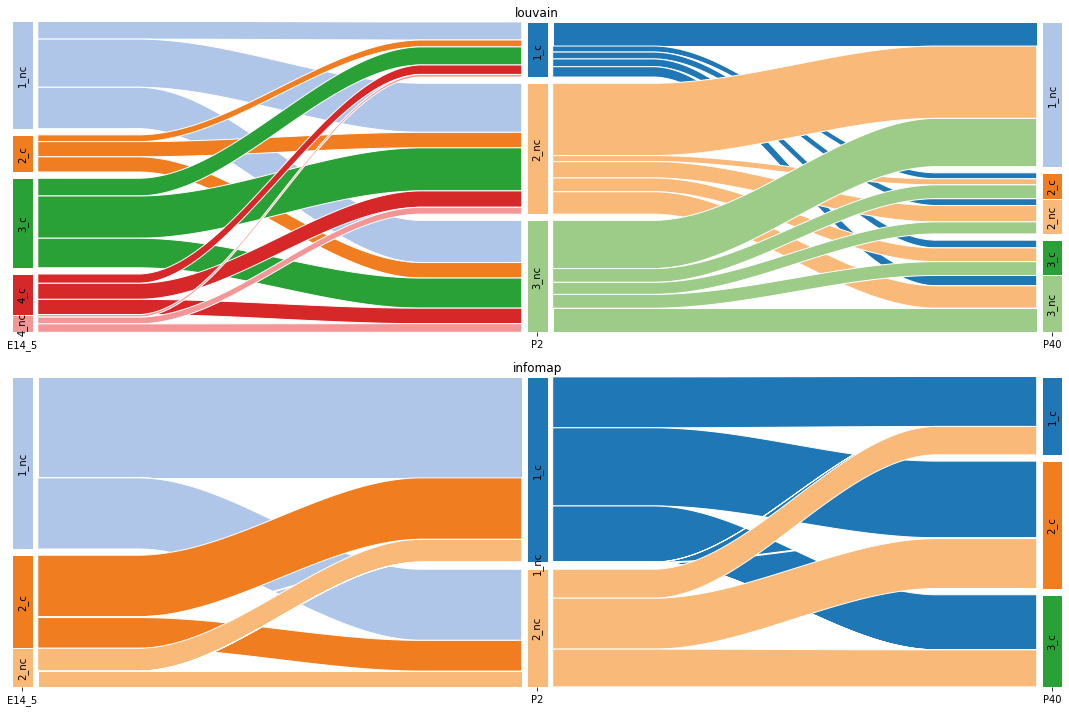

In [76]:
import pylluvial as pa
import matplotlib.pyplot as plt
tab20_colors = {
    '1_c': '#1F77B5',
    '1_nc': '#B0C6E8',
    '2_c': '#F07E21',
    '2_nc': '#F9BA79',
    '3_c': '#2AA137',
    '3_nc': '#9DCB88',
    '4_c': '#D62828',
    '4_nc': '#F29697',
    '5_c': '#8E67AA',
    '5_nc': '#C5B0D5'
}
colors = {
    k: tab20_colors for k in ['E14_5', 'P2', 'P40']
}
fig, axs = plt.subplots(2, 1)
for ax, cmethod in zip(axs, ['louvain', 'infomap']):
    data = results[cmethod]
    # this does not work properly in the plot
    # data = data[data.significant_core == 1]
    pa.alluvial(
        x = 'timepoint',
        stratum = 'remodule',
        alluvium = 'name',
        data = data,
        hue = 'recore',
        palette = colors,
        stratum_gap = 2,
        stratum_width = 2,
        ax = ax,
        show_labels = True
    )
    ax.set_title(cmethod)

fig.set_figwidth(15)
fig.set_figheight(10)
fig.tight_layout()
fig.savefig('../plots/wmcna_sigclu_recore.pdf')

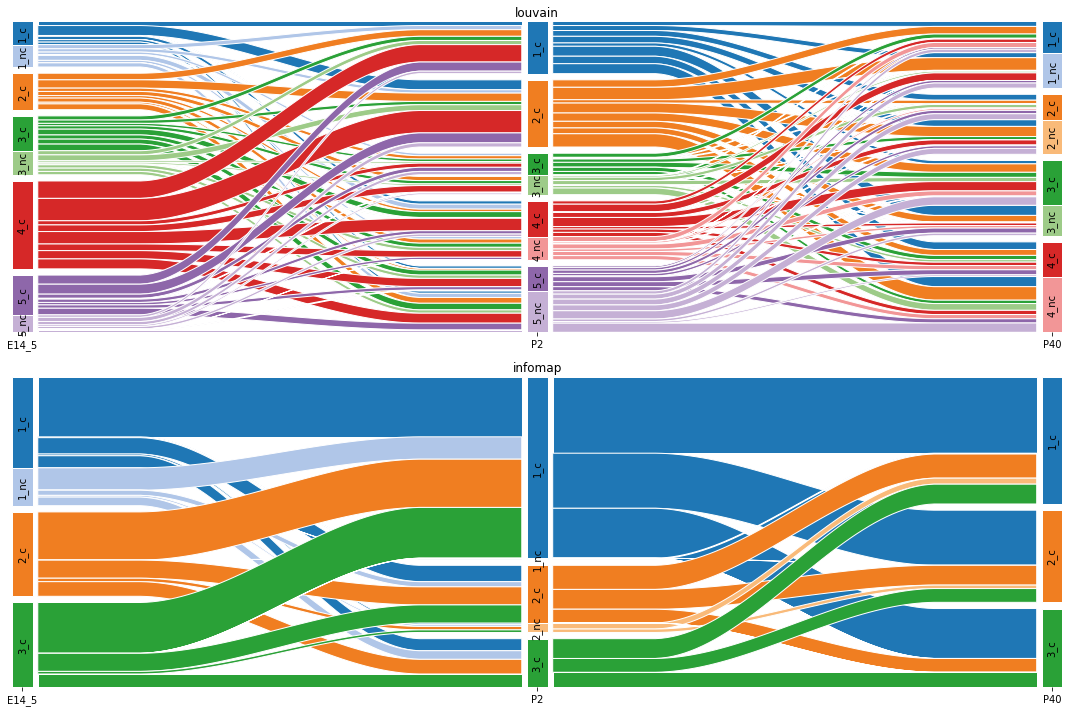

In [77]:
import pylluvial as pa
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1)
for ax, cmethod in zip(axs, ['louvain', 'infomap']):
    data = results[cmethod]
    # this does not work properly in the plot
    # data = data[data.significant_core == 1]
    pa.alluvial(
        x = 'timepoint',
        stratum = 'module',
        alluvium = 'name',
        data = data,
        hue = 'core',
        palette = colors,
        stratum_gap = 2,
        stratum_width = 2,
        ax = ax,
        show_labels = True
    )
    ax.set_title(cmethod)

fig.set_figwidth(15)
fig.set_figheight(10)
fig.tight_layout()
fig.savefig('../plots/wmcna_sigclu_core.pdf')

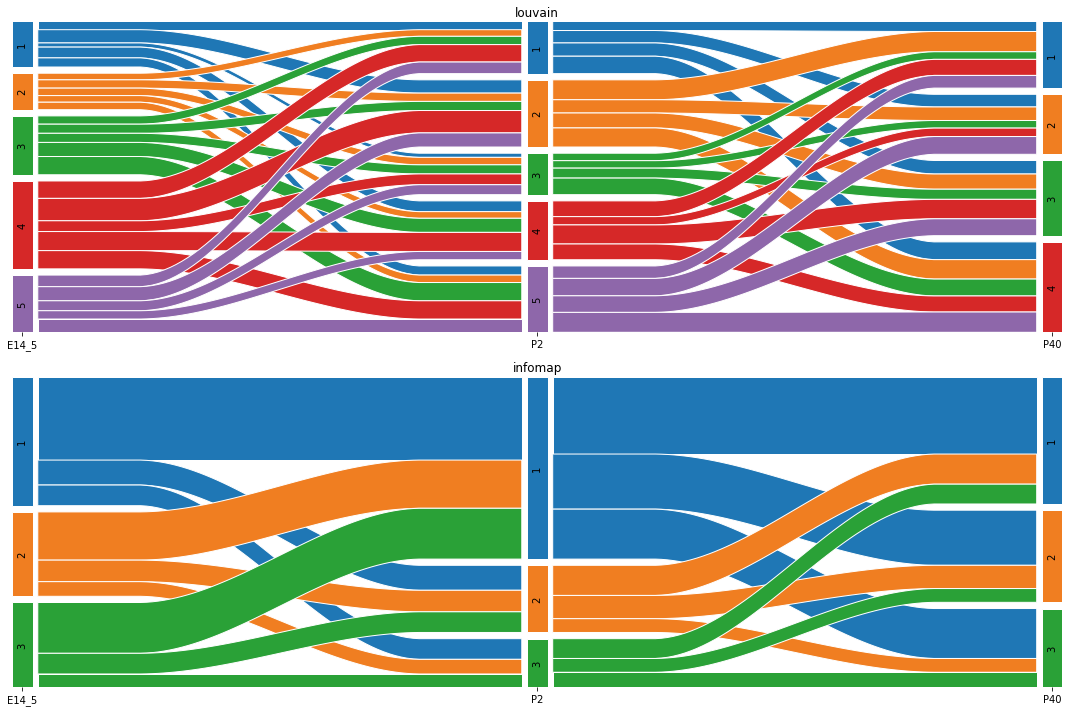

In [78]:
import pylluvial as pa
import matplotlib.pyplot as plt
tab20_colors = {
    1: '#1F77B5',
    2: '#F07E21',
    3: '#2AA137',
    4: '#D62828',
    5: '#8E67AA',
}

colors = {
    k: tab20_colors for k in ['E14_5', 'P2', 'P40']
}

fig, axs = plt.subplots(2, 1)
for ax, cmethod in zip(axs, ['louvain', 'infomap']):
    data = results[cmethod]
    # this does not work properly in the plot
    # data = data[data.significant_core == 1]
    pa.alluvial(
        x = 'timepoint',
        stratum = 'module',
        alluvium = 'name',
        data = data,
        palette = colors,
        stratum_gap = 2,
        stratum_width = 2,
        ax = ax,
        show_labels = True
    )
    ax.set_title(cmethod)

fig.set_figwidth(15)
fig.set_figheight(10)
fig.tight_layout()
fig.savefig('../plots/wmcna_sigclu_nosigclu.pdf')

In [10]:
# the following cells are a simple implementation of a pathway enrichment analysis
# based on differential abundance of compounds using Fisher's exact test
def compute_overlaps(diff_compounds, pathways, metabolites = None):
    '''
    computes overlaps between differentially regulated compounds and 
    each set of pathway compounds. Pathway compounds are limited to
    the set of compounds given by metabolites (i.e. adjustment to background
    aka only quantified metabolites are considered)
    '''
    diff_compounds = set(diff_compounds)
    overlaps = []
    for key, pathway in pathways.items():
        if 'COMPOUND' in pathway:
            pathway_metabolites = set(pathway['COMPOUND'].keys())
            if metabolites:
                pathway_metabolites = pathway_metabolites.intersection(
                    set(metabolites)
                )
            
            overlaps.append(
                [
                    key, 
                    pathway['NAME'][0],
                    len(
                        diff_compounds.intersection(
                            pathway_metabolites
                        )
                    ),
                    len(pathway_metabolites),
                    list(pathway_metabolites)
                ]
            )
    
    return pd.DataFrame(overlaps, columns = ['mapid', 'name', 'ncommon', 'ncompounds', 'compounds'])

# pvalue computation based on hypergeometric distribution
from scipy.stats import hypergeom
import numpy as np
def pvalue(k, M, n, N):
    """
    computes the probability to find k or more overlapping genes between two gene sets
    of n and N genes, where n is the number of genes in the gene set to which we overlap
    (i.e. number of genes in a pathway or number of differentially expressed genes in
    another patient) and N is the number of genes in the gene set which we are interested
    in (i.e. number of differentially expressed genes) which are drawn from M total genes
    (i.e. number of genes considered during differential expression analysis). This is also
    known as computing the pvalue for fisher's exact test.
    See http://www.pathwaycommons.org/guide/primers/statistics/fishers_exact_test/ for
    more information on how this is computed
    :param k:   number of common genes between two gene sets
    :param M:   total number of genes considered during DEA
    :param n:   number of genes in gene set with which we overlap
    :param N:   number of differentially expressed genes
    :return:    probability to find k or more common genes between the two gene sets
    """
    # k - 1 because we are computing P(x >= k) which includes k
    pval = hypergeom.sf(
        k - 1, M, n, N
    )
    return pval

In [4]:
pseudo_pathways = {}
for name, groupdf in basedata['HILIC'].groupby('metabolitegroupcoarse'):
    pathway = {
        'NAME': [name, ''],
        'COMPOUND': {
            row['ID'].upper(): row['Name'] for i, row in groupdf.iterrows()
        }
    }

    pseudo_pathways[name] = pathway

In [11]:
import pickle
def select_maps(pathwaydict, class_contains):
    selection = {}
    for k, v in pathwaydict.items():
        if 'CLASS' in v and any([pattern in v['CLASS'][0].lower() for pattern in class_contains]):
            selection[k] = v
            
    return selection

with open('../raw/kegg_pathway_maps.pickle', 'rb') as handle:
    pathwaymaps = pickle.load(handle)
    
selected_pathways = select_maps(
    pathwaymaps,
    ['metabolism', 'information processing']
)

In [35]:
from pylluvial.utils import pairwise
def get_significant_groups(df, metabolite_ids, group_col, clust_col, signif_col, signif_indicator = None):
    signif_clusters, signif_flows = dict(), dict()
    for k, group in df.groupby(group_col):
        signif_clusters[k] = {}
        for (c, s), clust in group.groupby([clust_col, signif_col]):
            if signif_indicator and not s == signif_indicator:
                continue

            else:
                signif_clusters[k]['_'.join(str(i) for i in [c, s])] = clust[metabolite_ids].to_list()
    
    # this implies that group_col is sorted in a way that successive
    # groups are really successive otherwise the pairwise function
    # will yield nonsensical results
    group_keys = df[group_col].unique()
    df = df.pivot(
        index = metabolite_ids,
        columns = group_col,
        values = [clust_col, signif_col]
    )
    idx = pd.IndexSlice
    for k1, k2 in pairwise(group_keys):
        signif_flows[(k1, k2)] = {}
        tmp = df.loc[:, idx[:, [k1, k2]]]
        if signif_indicator:
            signif_idx = \
                (tmp.loc[:, (signif_col, k1)] == signif_indicator) & \
                (tmp.loc[:, (signif_col, k2)] == signif_indicator)
        else:
            signif_idx = [True] * len(tmp)
            
        for (c1, c2), metabolites in tmp[signif_idx].groupby([(clust_col, k1), (clust_col, k2)]):
            signif_flows[(k1, k2)][(c1, c2)] = metabolites.index.to_list()
        
    return signif_clusters, signif_flows

def get_groups(df, metabolite_ids, group_col, clust_col):
    clusters, flows = dict(), dict()
    for k, group in df.groupby(group_col):
        clusters[k] = {}
        for c, clust in group.groupby(clust_col):
            clusters[k][c] = clust[metabolite_ids].to_list()
            
    group_keys = df[group_col].unique()
    df = df.pivot(
        index = metabolite_ids,
        columns = group_col,
        values = clust_col
    )
    idx = pd.IndexSlice
    for k1, k2 in pairwise(group_keys):
        flows[(k1, k2)] = {}
        tmp = df.loc[:, [k1, k2]]
        for (c1, c2), metabolites in tmp.groupby([k1, k2]):
            flows[(k1, k2)][(c1, c2)] = metabolites.index.to_list()
            
    return clusters, flows
                
sigclu_modules_recore, sigclu_flows_recore = {}, {}
sigclu_modules, sigclu_flows = {}, {}
modules, flows = {}, {}
for k in ['louvain', 'infomap']:
    sigclu_modules_recore[k], sigclu_flows_recore[k] = get_significant_groups(
        results[k],
        'name',
        'timepoint',
        'remodule',
        'recore'
    )
    sigclu_modules[k], sigclu_flows[k] = get_significant_groups(
        results[k],
        'name',
        'timepoint',
        'module',
        'core'
    )
    modules[k], flows[k] = get_groups(
        results[k],
        'name',
        'timepoint',
        'module'
    )

In [71]:
from statsmodels.stats.multitest import fdrcorrection
from IPython.display import display

def enrich_and_write_excel_modules(data, modules, excelfile, id_col, pathways, background):
    for cmethod, sig_d in modules.items():
        results[cmethod] = {}
        for i, (k, sig_m) in enumerate(sig_d.items()):
            results[cmethod][k] = {}
            for c, sig_c in sig_m.items():
                df = data.loc[sig_c, ['metabolitename', 'metabolitegroupcoarse', id_col]]
                df = df[~df[id_col].isna()]
                if df.empty:
                    continue

                enriched = compute_overlaps(
                    df[id_col],
                    pathways,
                    set(data[~data[id_col].isna()][id_col].unique())
                )

                enriched = enriched.loc[
                    ~((enriched.ncommon == 0) | (enriched.ncompounds == 0)), :
                ]
                
                if enriched.empty:
                    continue
                    
                enriched['pvalue'] = enriched.apply(
                    lambda x: pvalue(
                        x.ncommon, 
                        background, 
                        x.ncompounds, 
                        len(df)
                    ),
                    axis = 1
                )
                for values, col in zip(
                    fdrcorrection(enriched.pvalue, method = 'indep'),
                    ['reject', 'padj']
                ):
                    enriched[col] = values

                enriched.sort_values(
                    by = 'pvalue',
                    inplace = True
                )
                
                sheet_name = f'{k}-{c}'
                if i == 0:
                    with pd.ExcelWriter(
                        excelfile.format(cmethod = cmethod),
                        mode = 'w'
                    ) as writer:
                        enriched.to_excel(
                            writer,
                            sheet_name = sheet_name,
                            index = False
                        )

                    with pd.ExcelWriter(
                        excelfile.format(cmethod = cmethod),
                        mode = 'a',
                        if_sheet_exists = 'overlay'
                    ) as writer:
                        df.to_excel(
                            writer,
                            sheet_name = sheet_name,
                            startrow = len(enriched) + 2
                        )


                else:
                    with pd.ExcelWriter(
                        excelfile.format(cmethod = cmethod),
                        mode = 'a',
                        if_sheet_exists = 'overlay'
                    ) as writer:
                        enriched.to_excel(
                            writer,
                            sheet_name = sheet_name,
                            index = False
                        )
                        df.to_excel(
                            writer,
                            sheet_name = sheet_name,
                            startrow = len(enriched) + 2
                        )

for k1, pathways_dict, background, id_col in zip(
    ['kegg', 'custom'],
    [selected_pathways, pseudo_pathways],
    [178, 346],
    ['KEGG', 'ID']
):
    for k2, results_dict in zip(
        ['recore', 'core', 'nosigclu'],
        [sigclu_modules_recore, sigclu_modules, modules]
    ):
        enrich_and_write_excel_modules(
            basedata['HILIC'],
            results_dict,
            f'../results/wmcna_sigclu_modules_{k2}_{k1}_' + '{cmethod}.xlsx',
            id_col = id_col,
            pathways = pathways_dict,
            background = background
        )

In [73]:
from statsmodels.stats.multitest import fdrcorrection
def enrich_and_write_excel_flows(data, flows, excelfile, id_col, pathways, background):
    for cmethod, sig_d in flows.items():
        results[cmethod] = {}
        for i, (k, sig_m) in enumerate(sig_d.items()):
            results[cmethod][k] = {}
            for c, sig_c in sig_m.items():
                df = data.loc[sig_c, ['metabolitename', 'metabolitegroupcoarse', id_col]]
                df = df[~df[id_col].isna()]
                if df.empty:
                    continue
                
                enriched = compute_overlaps(
                    df[id_col],
                    pathways,
                    set(data[~data[id_col].isna()][id_col].unique())
                )
                
                enriched = enriched.loc[
                    ~((enriched.ncommon == 0) | (enriched.ncompounds == 0)), :
                ]

                enriched['pvalue'] = enriched.apply(
                    lambda x: pvalue(
                        x.ncommon, 
                        background, 
                        x.ncompounds, 
                        len(df)
                    ),
                    axis = 1
                )
                for values, col in zip(
                    fdrcorrection(enriched.pvalue, method = 'indep'),
                    ['reject', 'padj']
                ):
                    enriched[col] = values

                enriched.sort_values(
                    by = 'pvalue',
                    inplace = True
                )
                
                sheet_name = f'{k}-{c}'
                if i == 0:
                    with pd.ExcelWriter(
                        excelfile.format(cmethod = cmethod),
                        mode = 'w'
                    ) as writer:
                        enriched.to_excel(
                            writer,
                            sheet_name = sheet_name,
                            index = False
                        )

                    with pd.ExcelWriter(
                        excelfile.format(cmethod = cmethod),
                        mode = 'a',
                        if_sheet_exists = 'overlay'
                    ) as writer:
                        df.to_excel(
                            writer,
                            sheet_name = sheet_name,
                            startrow = len(enriched) + 2
                        )


                else:
                    with pd.ExcelWriter(
                        excelfile.format(cmethod = cmethod),
                        mode = 'a',
                        if_sheet_exists = 'overlay'
                    ) as writer:
                        enriched.to_excel(
                            writer,
                            sheet_name = sheet_name,
                            index = False
                        )
                        df.to_excel(
                            writer,
                            sheet_name = sheet_name,
                            startrow = len(enriched) + 2
                        )
                        
for k1, pathways_dict, background, id_col in zip(
    ['kegg', 'custom'],
    [selected_pathways, pseudo_pathways],
    [178, 346],
    ['KEGG', 'ID']
):
    for k2, results_dict in zip(
        ['recore', 'core', 'nosigclu'],
        [sigclu_flows_recore, sigclu_flows, flows]
    ):
        enrich_and_write_excel_flows(
            basedata['HILIC'],
            results_dict,
            f'../results/wmcna_sigclu_flows_{k2}_{k1}_' + '{cmethod}.xlsx',
            id_col = id_col,
            pathways = pathways_dict,
            background = background
        )